<a href="https://colab.research.google.com/github/ckkissane/deep_learning_curriculum/blob/ch-6-sol/solutions/6_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implement PPO and run it on Procgen. If you use the environments in easy mode, you'll be able to train on 1 GPU, which means you won't need to worry about data parallelism (though making a data-parallel implementation could be instructive).

In [ ]:
!pip install procgen

In [2]:
import os, time
import gym
from gym import spaces
from procgen import ProcgenEnv
import random
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import numpy as np
import pandas as pd
from collections import deque
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt

### utils

In [3]:
def set_global_seeds(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

### storage for trajectory info

In [4]:
class Storage():

    def __init__(self, obs_shape, num_steps, num_envs, device):
        self.obs_shape = obs_shape
        self.num_steps = num_steps
        self.num_envs = num_envs
        self.device = device
        self.reset()

    def reset(self):
        self.obs_batch = torch.zeros(self.num_steps+1, self.num_envs, *self.obs_shape)
        self.act_batch = torch.zeros(self.num_steps, self.num_envs)
        self.rew_batch = torch.zeros(self.num_steps, self.num_envs)
        self.done_batch = torch.zeros(self.num_steps, self.num_envs)
        self.log_prob_act_batch = torch.zeros(self.num_steps, self.num_envs)
        self.value_batch = torch.zeros(self.num_steps+1, self.num_envs)
        self.return_batch = torch.zeros(self.num_steps, self.num_envs)
        self.adv_batch = torch.zeros(self.num_steps, self.num_envs)
        self.info_batch = deque(maxlen=self.num_steps)
        self.step = 0

    def store(self, obs, act, rew, done, info, log_prob_act, value):
        self.obs_batch[self.step] = torch.from_numpy(obs.copy())
        self.act_batch[self.step] = torch.from_numpy(act.copy())
        self.rew_batch[self.step] = torch.from_numpy(rew.copy())
        self.done_batch[self.step] = torch.from_numpy(done.copy())
        self.log_prob_act_batch[self.step] = torch.from_numpy(log_prob_act.copy())
        self.value_batch[self.step] = torch.from_numpy(value.copy())
        self.info_batch.append(info)

        self.step = (self.step + 1) % self.num_steps

    def store_last(self, last_obs, last_value):
        self.obs_batch[-1] = torch.from_numpy(last_obs.copy())
        self.value_batch[-1] = torch.from_numpy(last_value.copy())

    def compute_estimates(self, gamma=0.99, lmbda=0.95):
        rew_batch = self.rew_batch
        # use_gae
        A = 0
        for i in reversed(range(self.num_steps)):
            rew = rew_batch[i]
            done = self.done_batch[i]
            value = self.value_batch[i]
            next_value = self.value_batch[i+1]

            delta = (rew + gamma * next_value * (1 - done)) - value
            self.adv_batch[i] = A = gamma * lmbda * A * (1 - done) + delta

        self.return_batch = self.adv_batch + self.value_batch[:-1]
        # normalize_adv
        adv_mean = torch.mean(self.adv_batch)
        adv_std = torch.std(self.adv_batch)
        print(f"adv_mean: {adv_mean}")
        print(f"adv_std: {adv_std}")
        self.adv_batch = (self.adv_batch - adv_mean) / (adv_std + 1e-8)


    def fetch_train_generator(self, mini_batch_size=None):
        batch_size = self.num_steps * self.num_envs
        if mini_batch_size is None:
            mini_batch_size = batch_size
        sampler = BatchSampler(SubsetRandomSampler(range(batch_size)),
                                mini_batch_size,
                                drop_last=True)
        for indices in sampler:
            obs_batch = torch.FloatTensor(self.obs_batch[:-1]).reshape(-1, *self.obs_shape)[indices].to(self.device)
            act_batch = torch.FloatTensor(self.act_batch).reshape(-1)[indices].to(self.device)
            done_batch = torch.FloatTensor(self.done_batch).reshape(-1)[indices].to(self.device)
            log_prob_act_batch = torch.FloatTensor(self.log_prob_act_batch).reshape(-1)[indices].to(self.device)
            value_batch = torch.FloatTensor(self.value_batch[:-1]).reshape(-1)[indices].to(self.device)
            return_batch = torch.FloatTensor(self.return_batch).reshape(-1)[indices].to(self.device)
            adv_batch = torch.FloatTensor(self.adv_batch).reshape(-1)[indices].to(self.device)
            yield obs_batch, act_batch, done_batch, log_prob_act_batch, value_batch, return_batch, adv_batch

    def fetch_log_data(self):
        if 'env_reward' in self.info_batch[0][0]:
            rew_batch = []
            for step in range(self.num_steps):
                infos = self.info_batch[step]
                rew_batch.append([info['env_reward'] for info in infos])
            rew_batch = np.array(rew_batch)
        else:
            rew_batch = self.rew_batch.numpy()
        if 'env_done' in self.info_batch[0][0]:
            done_batch = []
            for step in range(self.num_steps):
                infos = self.info_batch[step]
                done_batch.append([info['env_done'] for info in infos])
            done_batch = np.array(done_batch)
        else:
            done_batch = self.done_batch.numpy()
        return rew_batch, done_batch

### logger

In [5]:
class Logger(object):
    
    def __init__(self, n_envs, logdir):
        self.start_time = time.time()
        self.n_envs = n_envs
        self.logdir = logdir

        self.episode_rewards = []
        for _ in range(n_envs):
            self.episode_rewards.append([])
        self.episode_len_buffer = deque(maxlen = 40)
        self.episode_reward_buffer = deque(maxlen = 40)
        
        self.log = pd.DataFrame(columns = ['timesteps', 'wall_time', 'num_episodes',
                               'max_episode_rewards', 'mean_episode_rewards','min_episode_rewards',
                               'max_episode_len', 'mean_episode_len', 'min_episode_len'])
        self.timesteps = 0
        self.num_episodes = 0

    def feed(self, rew_batch, done_batch):
        steps = rew_batch.shape[0]
        rew_batch = rew_batch.T
        done_batch = done_batch.T

        for i in range(self.n_envs):
            for j in range(steps):
                self.episode_rewards[i].append(rew_batch[i][j])
                if done_batch[i][j]:
                    self.episode_len_buffer.append(len(self.episode_rewards[i]))
                    self.episode_reward_buffer.append(np.sum(self.episode_rewards[i]))
                    self.episode_rewards[i] = []
                    self.num_episodes += 1
        self.timesteps += (self.n_envs * steps)

    def write_summary(self, summary):
        for key, value in summary.items():
            print(f"{key}: {value}")

    def dump(self):
        wall_time = time.time() - self.start_time
        if self.num_episodes > 0:
            episode_statistics = self._get_episode_statistics()
            episode_statistics_list = list(episode_statistics.values())
        else:
            episode_statistics_list = [None] * 6
        log = [self.timesteps] + [wall_time] + [self.num_episodes] + episode_statistics_list
        self.log.loc[len(self.log)] = log

        with open(self.logdir + '/log.csv', 'w') as f:
            self.log.to_csv(f, index = False)
        print(self.log.loc[len(self.log)-1])

    def _get_episode_statistics(self):
        episode_statistics = {}
        episode_statistics['Rewards/max_episodes']  = np.max(self.episode_reward_buffer)
        episode_statistics['Rewards/mean_episodes'] = np.mean(self.episode_reward_buffer)
        episode_statistics['Rewards/min_episodes']  = np.min(self.episode_reward_buffer)
        episode_statistics['Len/max_episodes']  = np.max(self.episode_len_buffer)
        episode_statistics['Len/mean_episodes'] = np.mean(self.episode_len_buffer)
        episode_statistics['Len/min_episodes']  = np.min(self.episode_len_buffer)
        return episode_statistics

### impala model definition 

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = F.relu(x)
        out = self.conv1(out)
        out = F.relu(out)
        out = self.conv2(out)
        return out + x

class ImpalaBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.res1 = ResidualBlock(out_channels)
        self.res2 = ResidualBlock(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.maxpool(x)
        x = self.res1(x)
        x = self.res2(x)
        return x

class ImpalaModel(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.block1 = ImpalaBlock(in_channels=in_channels, out_channels=16)
        self.block2 = ImpalaBlock(in_channels=16, out_channels=32)
        self.block3 = ImpalaBlock(in_channels=32, out_channels=32)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=32 * 8 * 8, out_features=256)

        self.output_dim = 256

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = F.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = F.relu(x)
        return x

### Categorical policy definition

In [7]:
class CategoricalPolicy(nn.Module):
    def __init__(self, 
                 embedder,
                 action_size):
        """
        embedder: (torch.Tensor) model to extract the embedding for observation
        action_size: number of the categorical actions
        """ 
        super().__init__()
        self.embedder = embedder
        self.fc_policy = nn.Linear(self.embedder.output_dim, action_size)
        self.fc_value = nn.Linear(self.embedder.output_dim, 1)

    def forward(self, x):
        hidden = self.embedder(x)
        logits = self.fc_policy(hidden)
        p = Categorical(logits=logits)
        v = self.fc_value(hidden).reshape(-1)
        return p, v

### procgen vec_env wrappers

In [8]:
"""
See https://github.com/openai/baselines/tree/master/baselines/common/vec_env
"""

class VecEnv(ABC):
    """
    An abstract asynchronous, vectorized environment.
    Used to batch data from multiple copies of an environment, so that
    each observation becomes an batch of observations, and expected action is a batch of actions to
    be applied per-environment.
    """
    closed = False
    viewer = None

    metadata = {
        'render.modes': ['human', 'rgb_array']
    }

    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    @abstractmethod
    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a dict of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    @abstractmethod
    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    @abstractmethod
    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a dict of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    def close_extras(self):
        """
        Clean up the  extra resources, beyond what's in this base class.
        Only runs when not self.closed.
        """
        pass

    def close(self):
        if self.closed:
            return
        if self.viewer is not None:
            self.viewer.close()
        self.close_extras()
        self.closed = True

    def step(self, actions):
        """
        Step the environments synchronously.
        This is available for backwards compatibility.
        """
        self.step_async(actions)
        return self.step_wait()

    def render(self, mode='human'):
        imgs = self.get_images()
        bigimg = "ARGHH" #tile_images(imgs)
        if mode == 'human':
            self.get_viewer().imshow(bigimg)
            return self.get_viewer().isopen
        elif mode == 'rgb_array':
            return bigimg
        else:
            raise NotImplementedError

    def get_images(self):
        """
        Return RGB images from each environment
        """
        raise NotImplementedError

    @property
    def unwrapped(self):
        if isinstance(self, VecEnvWrapper):
            return self.venv.unwrapped
        else:
            return self

    def get_viewer(self):
        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.SimpleImageViewer()
        return self.viewer

    
class VecEnvWrapper(VecEnv):
    """
    An environment wrapper that applies to an entire batch
    of environments at once.
    """

    def __init__(self, venv, observation_space=None, action_space=None):
        self.venv = venv
        super().__init__(num_envs=venv.num_envs,
                        observation_space=observation_space or venv.observation_space,
                        action_space=action_space or venv.action_space)

    def step_async(self, actions):
        self.venv.step_async(actions)

    @abstractmethod
    def reset(self):
        pass

    @abstractmethod
    def step_wait(self):
        pass

    def close(self):
        return self.venv.close()

    def render(self, mode='human'):
        return self.venv.render(mode=mode)

    def get_images(self):
        return self.venv.get_images()

    def __getattr__(self, name):
        if name.startswith('_'):
            raise AttributeError("attempted to get missing private attribute '{}'".format(name))
        return getattr(self.venv, name)

    
class VecEnvObservationWrapper(VecEnvWrapper):
    @abstractmethod
    def process(self, obs):
        pass

    def reset(self):
        obs = self.venv.reset()
        return self.process(obs)

    def step_wait(self):
        obs, rews, dones, infos = self.venv.step_wait()
        return self.process(obs), rews, dones, infos

        
class VecExtractDictObs(VecEnvObservationWrapper):
    def __init__(self, venv, key):
        self.key = key
        super().__init__(venv=venv,
            observation_space=venv.observation_space.spaces[self.key])

    def process(self, obs):
        return obs[self.key]
    
    
class RunningMeanStd(object):
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count)

        
def update_mean_var_count_from_moments(mean, var, count, batch_mean, batch_var, batch_count):
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + np.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count


class VecNormalize(VecEnvWrapper):
    """
    A vectorized wrapper that normalizes the observations
    and returns from an environment.
    """

    def __init__(self, venv, ob=True, ret=True, clipob=10., cliprew=10., gamma=0.99, epsilon=1e-8):
        VecEnvWrapper.__init__(self, venv)

        self.ob_rms = RunningMeanStd(shape=self.observation_space.shape) if ob else None
        self.ret_rms = RunningMeanStd(shape=()) if ret else None
        
        self.clipob = clipob
        self.cliprew = cliprew
        self.ret = np.zeros(self.num_envs)
        self.gamma = gamma
        self.epsilon = epsilon

    def step_wait(self):
        obs, rews, news, infos = self.venv.step_wait()
        for i in range(len(infos)):
            infos[i]['env_reward'] = rews[i]
        self.ret = self.ret * self.gamma + rews
        obs = self._obfilt(obs)
        if self.ret_rms:
            self.ret_rms.update(self.ret)
            rews = np.clip(rews / np.sqrt(self.ret_rms.var + self.epsilon), -self.cliprew, self.cliprew)
        self.ret[news] = 0.
        return obs, rews, news, infos

    def _obfilt(self, obs):
        if self.ob_rms:
            self.ob_rms.update(obs)
            obs = np.clip((obs - self.ob_rms.mean) / np.sqrt(self.ob_rms.var + self.epsilon), -self.clipob, self.clipob)
            return obs
        else:
            return obs

    def reset(self):
        self.ret = np.zeros(self.num_envs)
        obs = self.venv.reset()
        return self._obfilt(obs)


class TransposeFrame(VecEnvWrapper):
    def __init__(self, env):
        super().__init__(venv=env)
        obs_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(obs_shape[2], obs_shape[0], obs_shape[1]), dtype=np.float32)

    def step_wait(self):
        obs, reward, done, info = self.venv.step_wait()
        return obs.transpose(0,3,1,2), reward, done, info

    def reset(self):
        obs = self.venv.reset()
        return obs.transpose(0,3,1,2)


class ScaledFloatFrame(VecEnvWrapper):
    def __init__(self, env):
        super().__init__(venv=env)
        obs_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=obs_shape, dtype=np.float32)

    def step_wait(self):
        obs, reward, done, info = self.venv.step_wait()
        return obs/255.0, reward, done, info

    def reset(self):
        obs = self.venv.reset()
        return obs/255.0

### PPO

In [9]:
class PPO:
    def __init__(self,
                 env,
                 policy,
                 logger,
                 storage,
                 device,
                 n_steps,
                 n_envs,
                 epoch,
                 mini_batch_per_epoch,
                 mini_batch_size,
                 gamma,
                 lmbda,
                 learning_rate,
                 eps_clip,
                 value_coef,
                 entropy_coef):

        self.env = env
        self.policy = policy
        self.logger = logger
        self.storage = storage
        self.device = device
        self.n_steps = n_steps
        self.n_envs = n_envs
        self.epoch = epoch
        self.mini_batch_per_epoch = mini_batch_per_epoch
        self.mini_batch_size = mini_batch_size
        self.gamma = gamma
        self.lmbda = lmbda
        self.learning_rate = learning_rate
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate, eps=1e-5)
        self.eps_clip = eps_clip
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef
        self.t = 0

    def predict(self, obs, done):
        with torch.no_grad():
            obs = torch.FloatTensor(obs).to(device=self.device)
            dist, value = self.policy(obs)
            act = dist.sample()
            log_prob_act = dist.log_prob(act)

        return act.cpu().numpy(), log_prob_act.cpu().numpy(), value.cpu().numpy()

    def optimize(self):
        pi_loss_list, value_loss_list, entropy_loss_list = [], [], []
        self.policy.train()
        for e in range(self.epoch):
            generator = self.storage.fetch_train_generator(mini_batch_size=self.mini_batch_size)
            for sample in generator:
                obs_batch, act_batch, done_batch, \
                    old_log_prob_act_batch, old_value_batch, return_batch, adv_batch = sample
                dist_batch, value_batch = self.policy(obs_batch)

                # Clipped Surrogate Objective
                log_prob_act_batch = dist_batch.log_prob(act_batch)
                ratio = torch.exp(log_prob_act_batch - old_log_prob_act_batch)
                surr1 = ratio * adv_batch
                surr2 = torch.clamp(ratio, 1.0 - self.eps_clip, 1.0 + self.eps_clip) * adv_batch
                pi_loss = -torch.min(surr1, surr2).mean()

                # useful info to log
                approx_kl = (old_log_prob_act_batch - log_prob_act_batch).mean().item()
                clipped = ratio.gt(1+self.eps_clip) | ratio.lt(1-self.eps_clip)
                clipfrac = torch.as_tensor(clipped, dtype=torch.float32).mean().item()

                # Clipped Bellman-Error
                clipped_value_batch = old_value_batch + (value_batch - old_value_batch).clamp(-self.eps_clip, self.eps_clip)
                v_surr1 = (value_batch - return_batch).pow(2)
                v_surr2 = (clipped_value_batch - return_batch).pow(2)
                value_loss = 0.5 * torch.max(v_surr1, v_surr2).mean()

                # Policy Entropy
                entropy_loss = dist_batch.entropy().mean()
                loss = pi_loss + self.value_coef * value_loss - self.entropy_coef * entropy_loss
                loss.backward()

                self.optimizer.step()
                self.optimizer.zero_grad()
                pi_loss_list.append(pi_loss.item())
                value_loss_list.append(value_loss.item())
                entropy_loss_list.append(entropy_loss.item())

        summary = {'loss/clipfrac': clipfrac,
                   'loss/approxkl': approx_kl,
                   'loss/policy_loss': np.mean(pi_loss_list),
                   'loss/value_loss': np.mean(value_loss_list),
                   'loss/policy_entropy': np.mean(entropy_loss_list)}
        return summary

    def train(self, num_timesteps):
        obs = self.env.reset()
        done = np.zeros(self.n_envs)

        while self.t < num_timesteps:
            # Run Policy
            self.policy.eval()
            for _ in range(self.n_steps):
                act, log_prob_act, value = self.predict(obs, done)
                next_obs, rew, done, info = self.env.step(act)
                self.storage.store(obs, act, rew, done, info, log_prob_act, value)
                obs = next_obs
            _, _, last_val = self.predict(obs, done)
            self.storage.store_last(obs, last_val)
            # Compute advantage estimates
            self.storage.compute_estimates(self.gamma, self.lmbda)

            # Optimize policy & valueq
            summary = self.optimize()
            # Log the training-procedure
            self.t += self.n_steps * self.n_envs
            rew_batch, done_batch = self.storage.fetch_log_data()
            self.logger.feed(rew_batch, done_batch)
            self.logger.write_summary(summary)
            self.logger.dump()
        self.env.close()

### train

In [ ]:
env_name = 'starpilot'
distribution_mode = 'easy'
num_timesteps = 25000000
seed = 3407

set_global_seeds(seed)

## HYPERPARAMETERS ##
print('[LOADING HYPERPARAMETERS...]')
hyperparameters = {
    'n_envs': 64,
    'n_steps': 256,
    'epoch': 3,
    'mini_batch_per_epoch': 8,
    'mini_batch_size': 2048,
    'gamma': 0.999,
    'lmbda': 0.95,
    'learning_rate': 0.0005,
    'eps_clip': 0.2,
    'value_coef': 0.5,
    'entropy_coef': 0.01,
}
for key, value in hyperparameters.items():
    print(key, ':', value)

## DEVICE ##
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## ENVIRONMENT ##
print('INITIALIZAING ENVIRONMENTS...')
n_envs = hyperparameters.get('n_envs')
env = ProcgenEnv(num_envs=n_envs,
                    env_name=env_name,
                    distribution_mode=distribution_mode)
env = VecExtractDictObs(env, "rgb")
env = VecNormalize(env, ob=False) # normalizing returns, but not the img frames.
env = TransposeFrame(env)
env = ScaledFloatFrame(env)

## LOGGER ##
print('INITIALIZAING LOGGER...')
logdir = 'procgen/' + env_name + '/' + 'seed' + '_' + \
            str(seed) + '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
logdir = os.path.join('logs', logdir)
if not (os.path.exists(logdir)):
    os.makedirs(logdir)
logger = Logger(n_envs, logdir)

## MODEL ##
print('INTIALIZING MODEL...')
observation_space = env.observation_space
observation_shape = observation_space.shape
in_channels = observation_shape[0]
action_space = env.action_space
assert isinstance(action_space, gym.spaces.Discrete)
model = ImpalaModel(in_channels=in_channels)
action_size = action_space.n
policy = CategoricalPolicy(model, action_size).to(device)

## STORAGE ##
print('INITIALIZAING STORAGE...')
n_steps = hyperparameters.get('n_steps')
storage = Storage(observation_shape, n_steps, n_envs, device)

## AGENT ##
print('INTIALIZING AGENT...')
agent = PPO(env, policy, logger, storage, device, **hyperparameters)

## TRAINING ##
print('START TRAINING...')
agent.train(num_timesteps)

In [11]:
df = pd.read_csv(logdir + '/log.csv')
df.head()

,timesteps,wall_time,num_episodes,max_episode_rewards,mean_episode_rewards,min_episode_rewards,max_episode_len,mean_episode_len,min_episode_len
0,16384.0,19.582341,175.0,12.0,2.075,0.0,186.0,82.525,23.0
1,32768.0,31.448236,382.0,6.0,1.000,0.0,137.0,70.725,19.0
2,49152.0,43.407000,579.0,7.0,1.375,0.0,177.0,79.075,18.0
3,65536.0,55.559462,774.0,14.0,2.525,0.0,241.0,90.300,39.0
4,81920.0,67.501515,958.0,11.0,2.350,0.0,160.0,87.000,31.0


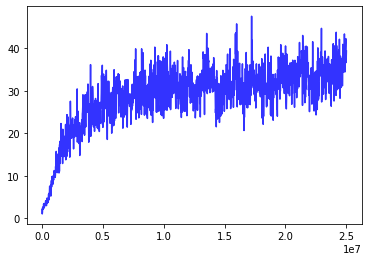

In [12]:
plt.plot(df['timesteps'], df['mean_episode_rewards'], 'b', alpha=0.8);
plt.show()